These are the first two nodes: [(267005894, {'y': 46.4849416, 'x': 11.2996093, 'street_count': 4, 'lts': '4', 'message': 'Node LTS is max intersecting LTS', 'lon': 11.2996093, 'lat': 46.4849416}), (1646275671, {'y': 46.4851877, 'x': 11.2984108, 'street_count': 3, 'lts': '1', 'message': 'Node LTS is max intersecting LTS', 'lon': 11.2984108, 'lat': 46.4851877})]
These are the first two edges: [(267005894, 1646275671, {'osmid': 258697000, 'name': ['Pista ciclabile Bolzano-Merano - Radweg Meran-Bozen'], 'highway': 'cycleway', 'length': 99.252, 'rule': 's3', 'lts': '1', 'slope': '1.7378467472171137', 'slope_class': '0-3: flat', 'message': "This way is a separated path because highway='cycleway'.", 'short_message': 'highway $=$ "cycleway"'}), (267005894, 7239401988, {'osmid': 278273512003091183557417086422661784435, 'name': ['Pista ciclabile Bolzano-Merano - Radweg Meran-Bozen'], 'highway': 'cycleway', 'length': 91.046, 'rule': 's3', 'lts': '1', 'slope': '2.3829989577216164', 'slope_class': 

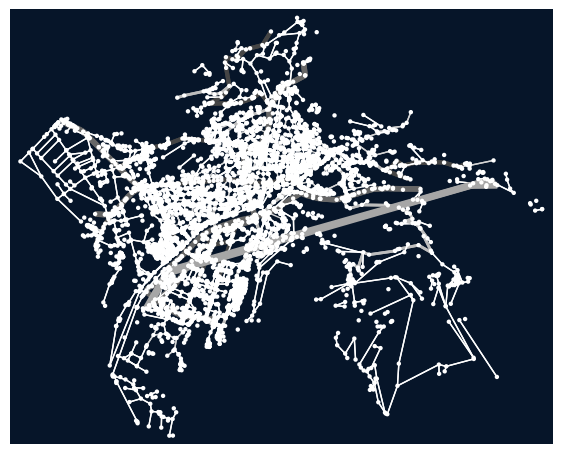

This are the node's attributes  {'y': 46.4849416, 'x': 11.2996093, 'street_count': 4, 'lts': '4', 'message': 'Node LTS is max intersecting LTS', 'lon': 11.2996093, 'lat': 46.4849416}
This are the edge's attributes: {'osmid': 258697000, 'name': ['Pista ciclabile Bolzano-Merano - Radweg Meran-Bozen'], 'highway': 'cycleway', 'length': 99.252, 'rule': 's3', 'lts': '1', 'slope': '1.7378467472171137', 'slope_class': '0-3: flat', 'message': "This way is a separated path because highway='cycleway'.", 'short_message': 'highway $=$ "cycleway"'}
These are the number of edges for each node: {267005894: 8, 1646275671: 2, 7239401988: 4, 5674491145: 4, 8434240003: 6, 267133300: 6, 1583197422: 4, 2786547818: 6, 1846590651: 4, 1583197433: 6, 279306719: 6, 3035646425: 2, 1434011049: 4, 9560555356: 4, 1729573646: 6, 3824904260: 4, 279306752: 6, 9516634718: 8, 1729573851: 6, 882424421: 8, 1729573798: 6, 9516634721: 2, 1582938305: 8, 1729573854: 6, 1729573880: 6, 279306774: 6, 9445681675: 4, 1693811621: 4,

In [1]:
import osmnx as ox
import os
import networkx as nx
from shapely.geometry import Point
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import collections
import matplotlib.patches as mpatches

base_path = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/images"
city_name = "Bolzano"

# Create the path for the new folder
city_folder_path = os.path.join(base_path, city_name)

# Create the folder if it doesn't exist
if not os.path.exists(city_folder_path):
    os.makedirs(city_folder_path)

# Load data
filepath = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Bolzano_lts.graphml"
G_lts = ox.load_graphml(filepath)
G_lts = ox.project_graph(G_lts, to_crs='EPSG:4326')
crs = G_lts.graph['crs']

# Basic Properties of the graph

## 1. Nodes and Edges
num_nodes = G_lts.number_of_nodes()
num_edges = G_lts.number_of_edges()

nodes = list(G_lts.nodes(data=True))
print("These are the first two nodes:", nodes[:2])
edges = list(G_lts.edges(data=True))
print("These are the first two edges:", edges[:2])

# Define a mapping for highway types to line widths and colors
highway_styles = {
    'motorway': {'linewidth': 5, 'color': "#a6a6a6"},
    'primary': {'linewidth': 4, 'color': "#676767"},
    'secondary': {'linewidth': 3, 'color': "#454545"},
    'tertiary': {'linewidth': 2, 'color': "#bdbdbd"},
    'residential': {'linewidth': 1, 'color': "#d5d5d5"},
    'default': {'linewidth': 1, 'color': "#ffff"} 
}

# Extract edge colors and widths based on the highway attribute
ec = [highway_styles[data['highway']]['color'] if data['highway'] in highway_styles else highway_styles['default']['color'] for _, _, data in G_lts.edges(data=True)]
lw = [highway_styles[data['highway']]['linewidth'] if data['highway'] in highway_styles else highway_styles['default']['linewidth'] for _, _, data in G_lts.edges(data=True)]

# Visualization
bgcolor = "#061529"
fig, ax = ox.plot_graph(G_lts, node_size=10,figsize=(7, 15), 
                        dpi=300, bgcolor=bgcolor,
                        save=False, edge_alpha=1,
                        edge_color=ec, edge_linewidth=lw)

fig.tight_layout(pad=0)

file_path = os.path.join(city_folder_path, 'network_base.png')
fig.savefig(file_path)

## Extracting Node IDs
node_ids = list(G_lts.nodes())

## Extracting Edge Nodes
edge_nodes = [(edge[0], edge[1]) for edge in edges]

## Node and edge attributes of the first obs.
node_id = node_ids[0]
node_attributes = G_lts.nodes[node_id]
print("This are the node's attributes ",node_attributes)

node1, node2 = edge_nodes[0]
edge_attributes = G_lts[node1][node2][0]
print("This are the edge's attributes:", edge_attributes)

## Degree of Nodes (namely: the number of edges connected to each node)
degrees = dict(G_lts.degree())
print("These are the number of edges for each node:", degrees)

## Function to round values in a dictionary
def round_dict_values(d):
    for key, value in d.items():
        if isinstance(value, float):
            d[key] = round(value, 2)
        elif isinstance(value, dict):
            d[key] = round_dict_values(value)
    return d

## Network density:
density = nx.density(G_lts)

## Triadic closure:
G_simple = nx.Graph(G_lts)
triadic_closure = nx.transitivity(G_simple)

## Some stats about the graph
stats = ox.basic_stats(G_lts)

## Print results
print(f'The number of nodes are: {num_nodes}')
print(f'The number of edges are: {num_edges}')
print(f'The average degree is: {round(sum(degrees.values()) / len(degrees), 2)}')
print(f'The network density is: {round(density,5)}')
print(f'The triadic closure of the simplified version of the graph is: {round(triadic_closure,5)}')
print(round_dict_values(stats))

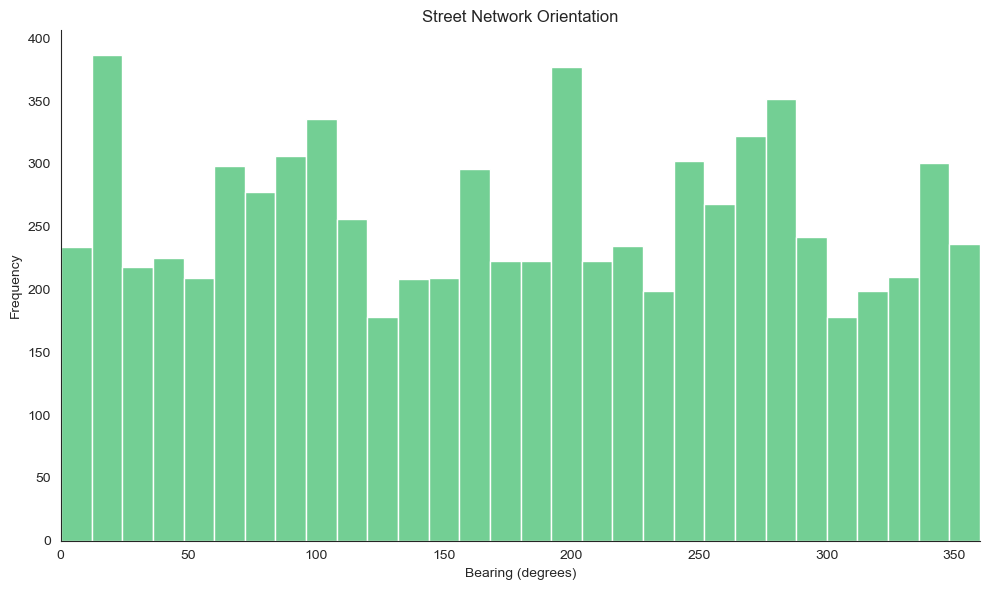

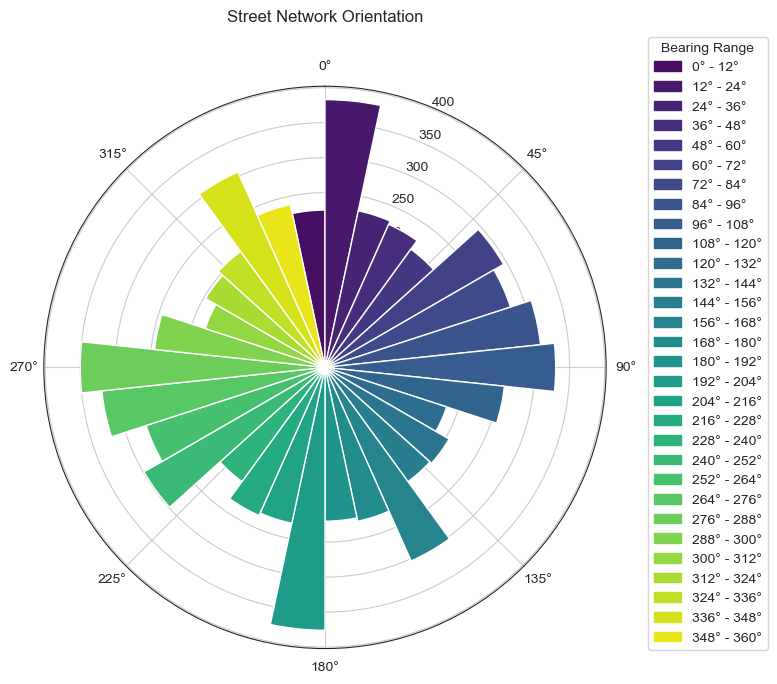

In [2]:
def plot_road_orientation(road, title='Street Network Orientation'):
    """
    Plot the street network orientation given a road graph.
    """
    # Set Seaborn style
    sns.set_style("white")
    
    # Calculate edge bearings
    road = ox.add_edge_bearings(road)
    bearings = pd.Series([data['bearing'] for u, v, k, data in road.edges(keys=True, data=True) if 'bearing' in data])
    
    # Histogram plot
    plt.figure(figsize=(10, 6))
    sns.histplot(bearings, bins=30, kde=False, color=sns.color_palette("viridis", as_cmap=True)(0.7))
    plt.xlim(0, 360)
    plt.title(title)
    plt.xlabel('Bearing (degrees)')
    plt.ylabel('Frequency')
    sns.despine()
    plt.tight_layout()
    file_path = os.path.join(city_folder_path, 'streetnetworkorientation_plot.png')
    plt.savefig(file_path)
    plt.show()
    
    # Polar plot
    n = 30
    count, division = np.histogram(bearings, bins=[ang*360/n for ang in range(0,n+1)])
    division = division[0:-1]
    width = 2 * np.pi/n
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')
    colors = sns.color_palette("viridis", n_colors=n)
    bars = ax.bar(division * np.pi/180 - width * 0.5, count, width=width, bottom=0.0, color=colors)
    ax.set_title(title, y=1.1)

    # Add legend to polar plot
    handles = [mpatches.Patch(color=colors[i], label='{}° - {}°'.format(int(division[i]), int(division[i]+360/n))) for i in range(n)]
    ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.3, 1.1), title="Bearing Range")
    file_path = os.path.join(city_folder_path, 'sno_polar_plot.png')
    plt.savefig(file_path)
    plt.tight_layout()
    plt.show()

# Use:
plot_road_orientation(G_lts, 'Street Network Orientation')